# Exploratory Data Analysis of SRTM Digital Elevation Model (DEM) Data

**Objective:** This notebook provides an exploratory data analysis (EDA) of the Shuttle Radar Topography Mission (SRTM) data for our region of interest in Southern California. This data provides high-resolution elevation information, which is critical for understanding the terrain where wildfires occur.

**Audience:** This analysis is for non-technical stakeholders to visualize and understand the topography of the area, including key landmarks and the specific terrain of the Santiago Fire perimeter.

**Methodology:** We will:
1.  Load the individual SRTM elevation tiles.
2.  Stitch these tiles together to create a single, seamless elevation map.
3.  Visualize the terrain, highlighting different elevation levels.
4.  Overlay key reference points and the Santiago Fire perimeter for context.

### 1. Setup and Dependencies

First, we need to set up our environment. This involves installing libraries for handling geospatial raster data (`rasterio`) and vector data (`geopandas`), as well as our standard tools for plotting. The following cell will install these if they are not already available.

In [1]:
%pip install rasterio geopandas matplotlib

import os
import glob
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt

print("Libraries installed and imported successfully!")

Note: you may need to restart the kernel to use updated packages.
Libraries installed and imported successfully!


### 2. Data Loading and Preparation

Next, we will define the paths to our data and load the necessary files. This includes finding all the SRTM `.tif` files, loading the Santiago Fire perimeter, and defining our reference points.

In [2]:
# Define paths
srtm_dir = '../../data/raw/SRTM/'
geojson_path = '../../data/santiago.geojson'
output_stitched_path = '../../data/processed/SRTM_stitched.tif'

# Find all SRTM tif files
srtm_files = glob.glob(os.path.join(srtm_dir, '*.tif'))

# Load the Santiago Fire perimeter
santiago_gdf = gpd.read_file(geojson_path)

# Define reference points
reference_points = {
    'Santiago Peak': (33.745, -117.533),
    'Long Beach': (33.770, -118.194),
    'UC Irvine': (33.640, -117.844),
    'Lake Mathews': (33.857, -117.424)
}

print(f"Found {len(srtm_files)} SRTM files to process.")
print("Santiago GeoJSON and reference points loaded.")

Found 6 SRTM files to process.
Santiago GeoJSON and reference points loaded.


### 3. Stitching SRTM Tiles

The SRTM data is provided in separate 1x1 degree tiles. To analyze the entire region seamlessly, we need to merge them into a single file. The following cell will open each tile and stitch them together into one larger GeoTIFF file. We will save this new file in the `data/processed` directory so we can easily reuse it for future analysis without repeating this step.

In [3]:
# Open all the files in a list
src_files_to_mosaic = [rasterio.open(fp) for fp in srtm_files]

# Merge the files
mosaic, out_trans = merge(src_files_to_mosaic)

# Get metadata from one of the source files and update it
out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({"driver": "GTiff",
                 "height": mosaic.shape[1],
                 "width": mosaic.shape[2],
                 "transform": out_trans,
                 })

# Write the stitched file to disk
with rasterio.open(output_stitched_path, "w", **out_meta) as dest:
    dest.write(mosaic)

# Close the source files
for src in src_files_to_mosaic:
    src.close()

print(f"Successfully stitched tiles and saved to {output_stitched_path}")

Successfully stitched tiles and saved to ../../data/processed/SRTM_stitched.tif


### 4. Visualizing the Stitched Elevation Data

Now that we have a single, unified elevation map, we can visualize it. The following plot shows the topography of our entire study area. We will use a color map where greens represent lower elevations (like coastal plains) and browns/whites represent higher elevations (like mountains). 

We will also overlay the Santiago Fire perimeter in red to see the specific terrain it burned across, and add our reference points to help with orientation.

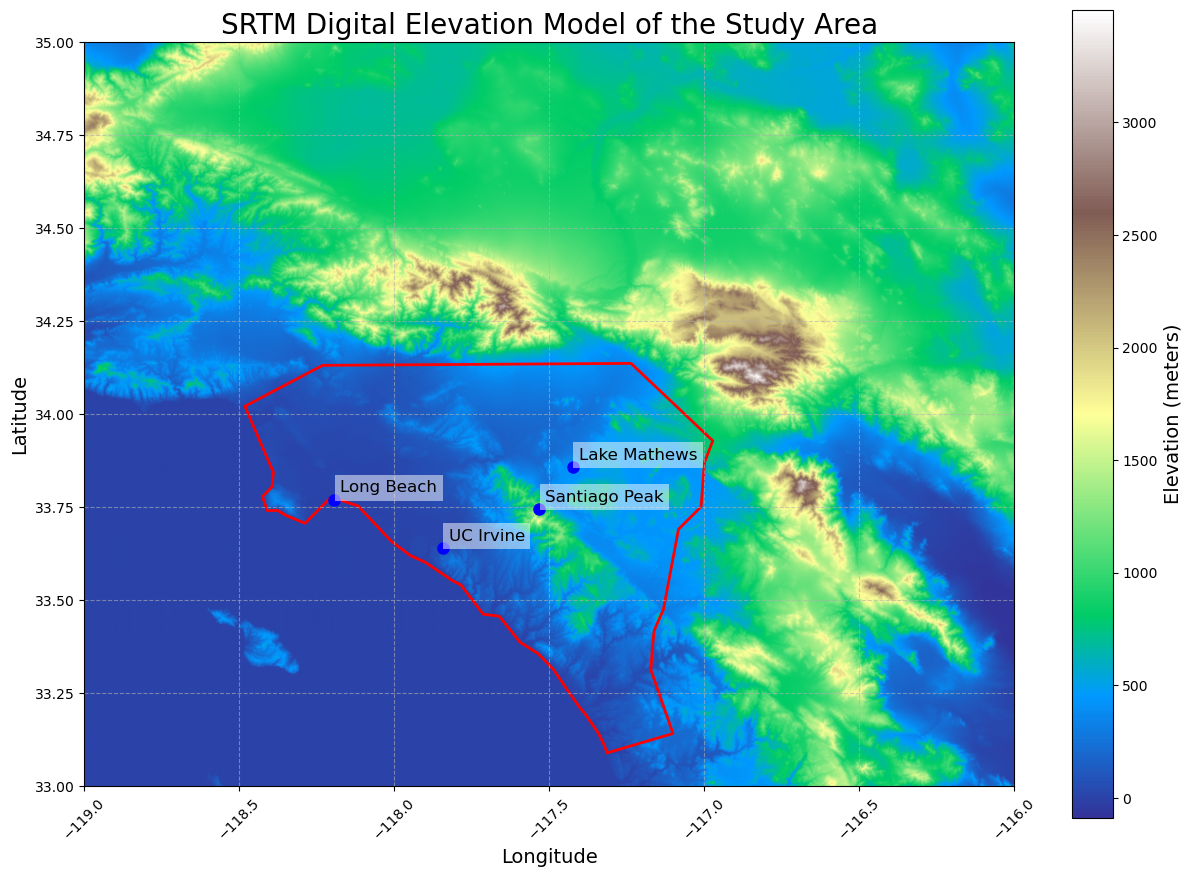

In [4]:
with rasterio.open(output_stitched_path) as src:
    fig, ax = plt.subplots(figsize=(15, 15))

    # Plot the raster data
    show(src, ax=ax, cmap='terrain')

    # Overlay the Santiago Fire perimeter
    santiago_gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2, label='Santiago Fire Perimeter')

    # Plot reference points
    for name, (lat, lon) in reference_points.items():
        ax.plot(lon, lat, 'bo', markersize=8, label=name)
        ax.text(lon + 0.02, lat + 0.02, name, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

    # Customize the plot
    ax.set_title('SRTM Digital Elevation Model of the Study Area', fontsize=20)
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Add a color bar for elevation
    sm = plt.cm.ScalarMappable(cmap='terrain', norm=plt.Normalize(vmin=src.read(1).min(), vmax=src.read(1).max()))
    sm._A = [] # Empty array for the data range
    cbar = fig.colorbar(sm, ax=ax, shrink=0.7)
    cbar.set_label('Elevation (meters)', fontsize=14)

    plt.show()

### 5. Interpretation and Conclusion

The map above provides a clear picture of the region's topography. We can easily identify major features:

*   **The Santa Ana Mountains:** The prominent mountain range running through the center of the map, where Santiago Peak is located.
*   **Coastal Plains:** The flat, low-lying areas near the coast, where Long Beach and UC Irvine are situated.
*   **Inland Valleys:** The lower elevation areas to the east.

The **Santiago Fire perimeter** is clearly visible in red, primarily covering the rugged, high-elevation terrain of the Santa Ana Mountains. This immediately tells us that the fire burned in a complex topographical area, which has significant implications for fire behavior (e.g., fires tend to move faster uphill) and for the challenges faced by firefighting crews.

This stitched elevation map serves as a foundational layer for many other types of analysis, from understanding weather patterns to modeling wildfire spread.